# Task

In [25]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

DATA_ROOT = Path("../../scratch/data/downstream_multidb/mitdb/beat")  # change if needed

X_train = np.load(DATA_ROOT / "X_train.npy", allow_pickle=True)
y_train = np.load(DATA_ROOT / "y_train.npy", allow_pickle=True)

X_val = np.load(DATA_ROOT / "X_val.npy", allow_pickle=True)
y_val = np.load(DATA_ROOT / "y_val.npy", allow_pickle=True)

X_test = np.load(DATA_ROOT / "X_test.npy", allow_pickle=True)
y_test = np.load(DATA_ROOT / "y_test.npy", allow_pickle=True)

print("train:", X_train.shape, y_train.shape, X_train.dtype, y_train.dtype)
print("val  :", X_val.shape, y_val.shape)
print("test :", X_test.shape, y_test.shape)

AAMI_CLASSES = ["N", "S", "V", "F", "Q"]
for name, y in [("train", y_train), ("val", y_val), ("test", y_test)]:
    counts = np.bincount(y.astype(np.int64), minlength=len(AAMI_CLASSES))
    print(name, "counts:", counts.tolist())

train: (77833, 300) (77833,) float32 int64
val  : (11652, 300) (11652,)
test : (19975, 300) (19975,)
train counts: [64865, 2651, 5746, 417, 4154]
val counts: [11363, 70, 213, 6, 0]
test counts: [14372, 60, 1276, 379, 3888]


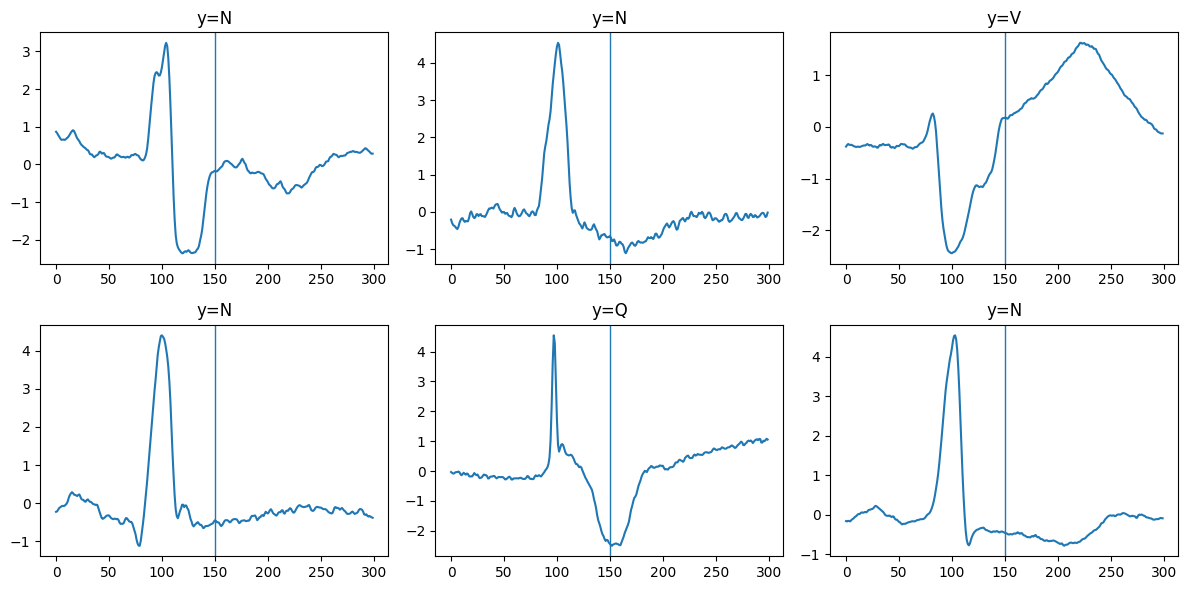

In [26]:
rng = np.random.default_rng(0)
idx = rng.choice(len(X_train), size=6, replace=False)

plt.figure(figsize=(12, 6))
for i, k in enumerate(idx, 1):
    plt.subplot(2, 3, i)
    plt.plot(X_train[k])
    plt.title(f"y={AAMI_CLASSES[int(y_train[k])]}")
    plt.axvline(len(X_train[k]) // 2, linewidth=1)  # center reference
plt.tight_layout()
plt.show()

- What: Build a PyTorch dataset for downstream training.
- Why: DataLoader gives batching, shuffling, and clean integration with training loops.
- How: Wrap numpy arrays and return tensors with the expected shapes.

已经有 FM model。我们先做 linear probe：

- encoder 冻结
- 只训练 head

What: Train a linear classifier on top of the pretrained encoder (linear probe).
Why: This quickly validates the downstream pipeline and measures representation quality.
How: Freeze encoder parameters and train only a small classification head.

In [27]:
import os
import json
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from src.ecg_fm.data.downstream_dataset import NpyECGDataset
from src.ecg_fm.models.mae_ecg import ECGMAE_1D
from src.ecg_fm.models.mae_classifier import (
    ECGEncoderForClassification,
    freeze_encoder,
    unfreeze_encoder,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

DATA_DIR = "../../scratch/data/downstream_multidb/mitdb/beat"  # notebook在notebooks/里，所以用../
X_train = os.path.join(DATA_DIR, "X_train.npy")
y_train = os.path.join(DATA_DIR, "y_train.npy")
X_val = os.path.join(DATA_DIR, "X_val.npy")
y_val = os.path.join(DATA_DIR, "y_val.npy")
X_test = os.path.join(DATA_DIR, "X_test.npy")
y_test = os.path.join(DATA_DIR, "y_test.npy")

# 你的 MAE 预训练权重（你自己改成实际路径）
MAE_CKPT = "../FYP/outputs/runs/2025-12-28_1610_mae_multidb/checkpoints/best.pt"

OUT_DIR = "../FYP/outputs/downstream/run_debug"
os.makedirs(OUT_DIR, exist_ok=True)

device: cpu


In [28]:
train_ds = NpyECGDataset(X_train, y_train)
val_ds = NpyECGDataset(X_val, y_val)
test_ds = NpyECGDataset(X_test, y_test)

print("train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))
x0, y0 = train_ds[0]
print("one sample x shape:", x0.shape, "y:", y0)

# infer basic params
n_leads = x0.shape[0]
seq_len = x0.shape[1]
num_classes = int(np.max(np.load(y_train))) + 1  # 简单推断类别数（你也可以手动写死）
print("n_leads:", n_leads, "seq_len:", seq_len, "num_classes:", num_classes)

train: 77833 val: 11652 test: 19975
one sample x shape: torch.Size([1, 300]) y: tensor(0)
n_leads: 1 seq_len: 300 num_classes: 5


In [29]:
batch_size = 128
num_workers = 2

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

In [30]:
# IMPORTANT: these params must match your pretraining model definition
patch_size = 10
d_model = 128
enc_depth = 4
dec_depth = 2
n_heads = 4
dim_ff = 256
dropout = 0.1

mae = ECGMAE_1D(
    n_leads=n_leads,  # 确认这里 = 1，因为 ckpt 里权重是 [128, 1, 10]
    patch_size=patch_size,
    d_model=d_model,
    enc_depth=enc_depth,  # = 4
    dec_depth=dec_depth,  # 一般=2，得和训练时一致/默认一致
    n_heads=n_heads,
    dim_ff=dim_ff,
    dropout=dropout,
    mask_ratio=0.6,  # 这对加载权重没影响，只影响训练过程
    pos_max_len=4096,  # 如果是可学习的位置编码，也要和训练代码一致（通常没问题）
).to(device)

ckpt = torch.load(MAE_CKPT, map_location="cpu")

if isinstance(ckpt, dict) and "state_dict" in ckpt:
    state = ckpt["state_dict"]
elif isinstance(ckpt, dict) and "model" in ckpt:
    state = ckpt["model"]
elif isinstance(ckpt, dict):
    state = ckpt
else:
    raise ValueError("Unknown checkpoint format")

missing, unexpected = mae.load_state_dict(state, strict=False)
print("missing keys:", len(missing))
print("unexpected keys:", len(unexpected))

missing keys: 0
unexpected keys: 0


In [31]:
model = ECGEncoderForClassification(mae=mae, n_classes=num_classes, pool="mean").to(
    device
)

# Linear probing: freeze encoder, train only classifier head
freeze_encoder(model)

# sanity: count trainable params
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"trainable params: {trainable} / {total}")

trainable params: 645 / 798351


In [32]:
from collections import defaultdict


def accuracy_from_logits(logits, y):
    pred = torch.argmax(logits, dim=1)
    return (pred == y).float().mean().item()


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    losses = []
    accs = []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        accs.append(accuracy_from_logits(logits, y))
    return float(np.mean(losses)), float(np.mean(accs))


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    losses = []
    accs = []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accs.append(accuracy_from_logits(logits, y))
    return float(np.mean(losses)), float(np.mean(accs))

In [33]:
lr = 1e-3
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4
)

best_val_acc = -1.0
history = defaultdict(list)

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc = evaluate(model, val_loader, criterion)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(
        f"[EP {ep:02d}] train loss={tr_loss:.4f} acc={tr_acc:.4f} | val loss={va_loss:.4f} acc={va_acc:.4f}"
    )

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(
            {"model": model.state_dict(), "epoch": ep, "val_acc": va_acc},
            os.path.join(OUT_DIR, "best.pt"),
        )

torch.save(
    {"model": model.state_dict(), "epoch": epochs, "val_acc": best_val_acc},
    os.path.join(OUT_DIR, "last.pt"),
)

with open(os.path.join(OUT_DIR, "history.json"), "w") as f:
    json.dump(history, f, indent=2)

print("best val acc:", best_val_acc)

[EP 01] train loss=0.4235 acc=0.8693 | val loss=0.1366 acc=0.9775
[EP 02] train loss=0.3124 acc=0.9156 | val loss=0.1416 acc=0.9777
[EP 03] train loss=0.2837 acc=0.9240 | val loss=0.1391 acc=0.9777
[EP 04] train loss=0.2717 acc=0.9266 | val loss=0.1360 acc=0.9778
[EP 05] train loss=0.2643 acc=0.9286 | val loss=0.1351 acc=0.9780
[EP 06] train loss=0.2560 acc=0.9314 | val loss=0.1323 acc=0.9779
[EP 07] train loss=0.2502 acc=0.9317 | val loss=0.1354 acc=0.9778
[EP 08] train loss=0.2477 acc=0.9331 | val loss=0.1301 acc=0.9777
[EP 09] train loss=0.2443 acc=0.9325 | val loss=0.1330 acc=0.9778
[EP 10] train loss=0.2425 acc=0.9343 | val loss=0.1474 acc=0.9767
best val acc: 0.9780061141304348


In [34]:
import numpy as np


def label_stats(y_path, name):
    y = np.load(y_path)
    classes, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    print(f"\n[{name}] total={total}")
    for c, k in zip(classes, counts):
        print(f"  class {int(c)}: {int(k)} ({k/total:.4%})")


label_stats(y_train, "train")
label_stats(y_val, "val")
label_stats(y_test, "test")


[train] total=77833
  class 0: 64865 (83.3387%)
  class 1: 2651 (3.4060%)
  class 2: 5746 (7.3825%)
  class 3: 417 (0.5358%)
  class 4: 4154 (5.3371%)

[val] total=11652
  class 0: 11363 (97.5197%)
  class 1: 70 (0.6008%)
  class 2: 213 (1.8280%)
  class 3: 6 (0.0515%)

[test] total=19975
  class 0: 14372 (71.9499%)
  class 1: 60 (0.3004%)
  class 2: 1276 (6.3880%)
  class 3: 379 (1.8974%)
  class 4: 3888 (19.4643%)


In [35]:
import numpy as np

y = np.load(y_train)
majority = np.bincount(y).argmax()
baseline_acc = (np.load(y_val) == majority).mean()
print("majority class:", majority)
print("val majority baseline acc:", baseline_acc)

majority class: 0
val majority baseline acc: 0.9751973910058359


In [36]:
import torch
import numpy as np


@torch.no_grad()
def collect_preds(model, loader):
    model.eval()
    ys, ps = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        pred = torch.argmax(logits, dim=1).cpu().numpy()
        ys.append(y.numpy())
        ps.append(pred)
    return np.concatenate(ys), np.concatenate(ps)


def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm


y_true, y_pred = collect_preds(model, val_loader)
cm = confusion_matrix(y_true, y_pred, num_classes=num_classes)
print("Confusion matrix (rows=true, cols=pred):\n", cm)
print("Per-class recall:", np.diag(cm) / (cm.sum(axis=1) + 1e-12))

Confusion matrix (rows=true, cols=pred):
 [[11327    18    18     0     0]
 [   70     0     0     0     0]
 [  162     0    51     0     0]
 [    5     0     1     0     0]
 [    0     0     0     0     0]]
Per-class recall: [0.99683182 0.         0.23943662 0.         0.        ]


In [37]:
ckpt = torch.load(os.path.join(OUT_DIR, "best.pt"), map_location="cpu")
model.load_state_dict(ckpt["model"])
model.to(device)

te_loss, te_acc = evaluate(model, test_loader, criterion)
print("TEST:", "loss=", te_loss, "acc=", te_acc)

TEST: loss= 0.4084759136650023 acc= 0.880310225258967


In [38]:
# Unfreeze and fine-tune
unfreeze_encoder(model)

# usually smaller lr for backbone
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

# repeat training loop for e.g. 20~50 epochs